# Hospital Readmission Prediction - Neural Networks

This notebook contain the code for Candian Hospital Re-Admission using neural networks.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from pprint import pprint

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import optuna

import gc
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Reading the appropriate data and storing it in the dataframe.


In [3]:
df = pd.read_csv("./processed_data.csv")

In [4]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

# for col in X.columns:
#     if (col == 'readmission_id'):
#         print(col)

Code for Neural Network with 4 input layers and one ouput layers.

In [5]:
class ANN(nn.Module):
    def __init__(
        self,
        in_dim: int,
        hidden_dim_1: int,
        hidden_dim_2: int,
        hidden_dim_3: int,
        hidden_dim_4: int,
        n_classes:int = 3,
        dropout: float = 0.3
    ):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=hidden_dim_1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim_1),
            nn.Dropout(dropout),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(in_features=hidden_dim_1, out_features=hidden_dim_2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim_2),
            nn.Dropout(dropout),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(in_features=hidden_dim_2, out_features=hidden_dim_3),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim_3),
            nn.Dropout(dropout),
        )
        self.layer4 = nn.Sequential(
            nn.Linear(in_features=hidden_dim_3, out_features=hidden_dim_4),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim_4),
            nn.Dropout(dropout),
        )
        self.output_layer = nn.Linear(in_features=hidden_dim_4, out_features=n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
            Args:
                x (torch.Tensor): (batch_size, in_dim) the input

            Output:
                (torch.Tensor): (batch_size, n_classes) the output
        """
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.output_layer(x)

        return x

In [6]:
class Data(Dataset):
    def __init__(
        self,
        data
    ):
        n = data.shape[1]
        self.features = torch.tensor(data.iloc[:, 0:n-1].values.astype(np.int64), dtype=torch.float32)
        self.labels = torch.tensor(data.iloc[:, -1].values.astype(np.int64), dtype=torch.int64)
    # def _build(self):
        # scaler = MinMaxScaler(feature_range=())
        # scaler = StandardScaler()

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return len(self.features)

Doing the required test,train split with 80:20 ration respectively.

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
X_train = pd.DataFrame(X_train)
Y_train = pd.DataFrame(Y_train)
X_test = pd.DataFrame(X_test)
Y_test = pd.DataFrame(Y_test)

X_train = pd.concat([X_train, Y_train], axis=1)
X_test = pd.concat([X_test, Y_test], axis=1)

In [8]:
print(X_train.dtypes)

admission_source_id_new_1     bool
admission_source_id_new_2     bool
admission_source_id_new_3     bool
admission_source_id_new_4     bool
admission_source_id_new_5     bool
                             ...  
number_outpatient            int64
patient_id_new               int64
service_utilization          int64
time_in_hospital             int64
readmission_id               int64
Length: 137, dtype: object


Passing the split data into the custom Data class for organization.

In [9]:
train_dataset = Data(data=X_train)
test_dataset = Data(data=X_test)

Setting the batch size.

In [10]:
train_batchsize = 512
val_batchsize = 512

Loading the data into DataLoaded which will then make it useful for loading and handling the pre-processed data into the neural networks.

In [11]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batchsize, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=val_batchsize, shuffle=True)

In [12]:
n_epochs = 5

In [13]:
in_dim = X.shape[1]
in_dim

136

In [14]:
model = ANN(
    in_dim=in_dim,
    hidden_dim_1=in_dim//2,
    hidden_dim_2=in_dim//4,
    hidden_dim_3=in_dim//8,
    hidden_dim_4=3
).to(device)

Using `Adam` optimizer and `Cross Entropy Loss` for fitting of our model.

In [15]:
lr = 1e-3
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

loss_fn = torch.nn.CrossEntropyLoss()

In [16]:
sanity_check=False

Epoch Code that takes cares of each iteration and uses the Adam optimizer defined above.

In [17]:
def train_epoch(
    model,
    dataloader,
    optimiser
):
    model.train()

    for batch in tqdm(dataloader):
        x, y = batch[0], batch[1]

        output = model(x)
        output = nn.Softmax(dim=-1)(output)
        loss = loss_fn(output, y)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if sanity_check:
            break

def validate(
    model,
    dataloader
):
    model.eval()
    total_loss = 0
    predictions = []
    truths = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            x, y = batch[0], batch[1]

            output = model(x)
            output = nn.Softmax(dim=-1)(output)
            loss = loss_fn(output, y)
            total_loss += loss.detach().cpu().item()/len(dataloader)

            preds = torch.argmax(output, dim=-1)
            predictions.extend(preds.cpu())
            truths.extend(y.cpu())

            if sanity_check:
                break

    acc = accuracy_score(y_true=truths, y_pred=predictions)
    f1 = f1_score(y_true=truths, y_pred=predictions, average='macro')

    return total_loss, acc, f1

Training Model code

In [18]:
def train_model(
    model,
    train_dataloader,
    test_dataloader,
    optimiser
):
    for epoch in range(1, n_epochs+1):
        start_time = time.time()

        print(f"========= EPOCH {epoch} STARTED =========")
        train_epoch(model=model, dataloader=train_dataloader, optimiser=optimiser)

        print(f"========= TRAIN EVALUATION STARTED =========")
        train_val_op = validate(model=model, dataloader=train_dataloader)

        print(f"========= TEST EVALUATION STARTED =========")
        test_val_op = validate(model=model, dataloader=test_dataloader)

        print(f"END OF {epoch} EPOCH")
        print(f"| Time taken: {time.time() - start_time: 7.3f} |")
        print(f"| Train Loss: {train_val_op[0]: 7.3f} | Train acc: {train_val_op[1]: 1.5f} | Train f1: {train_val_op[2]: 1.5f} |")
        print(f"| Test Loss: {test_val_op[0]: 7.3f}  | Test acc: {test_val_op[1]: 1.5f}  | Test f1: {test_val_op[2]: 1.5f}  |")

        if sanity_check:
            break

In [19]:
train_model(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimiser=optimiser
)

========= EPOCH 1 STARTED =========


100%|██████████| 112/112 [00:01<00:00, 91.89it/s] 


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:01<00:00, 104.86it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 144.74it/s]


END OF 1 EPOCH
| Time taken:   8.461 |
| Train Loss:   1.000 | Train acc:  0.63991 | Train f1:  0.43530 |
| Test Loss:   1.002  | Test acc:  0.63574  | Test f1:  0.43152  |
========= EPOCH 2 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 121.05it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 124.50it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 69.15it/s] 


END OF 2 EPOCH
| Time taken:   8.118 |
| Train Loss:   0.896 | Train acc:  0.69725 | Train f1:  0.47841 |
| Test Loss:   0.898  | Test acc:  0.69350  | Test f1:  0.47492  |
========= EPOCH 3 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 112.73it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 131.57it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 136.16it/s]


END OF 3 EPOCH
| Time taken:   8.153 |
| Train Loss:   0.865 | Train acc:  0.71278 | Train f1:  0.48842 |
| Test Loss:   0.869  | Test acc:  0.70663  | Test f1:  0.48319  |
========= EPOCH 4 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 117.07it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:01<00:00, 104.83it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 166.29it/s]


END OF 4 EPOCH
| Time taken:   8.211 |
| Train Loss:   0.841 | Train acc:  0.71720 | Train f1:  0.48999 |
| Test Loss:   0.846  | Test acc:  0.71189  | Test f1:  0.48542  |
========= EPOCH 5 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 115.03it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 118.53it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 170.64it/s]


END OF 5 EPOCH
| Time taken:   7.865 |
| Train Loss:   0.837 | Train acc:  0.71852 | Train f1:  0.49032 |
| Test Loss:   0.841  | Test acc:  0.71435  | Test f1:  0.48644  |


In [20]:
test_data = torch.tensor(X_test.iloc[:, 0:-1].values.astype(np.int64), dtype=torch.float32)
print(model.forward(test_data))

tensor([[-1.6961, -2.2239,  2.4339],
        [ 0.7525,  3.3789, -1.4703],
        [-2.0583, -2.7529,  2.7549],
        ...,
        [ 0.8503,  3.9909, -1.7721],
        [ 0.4938,  3.1449, -1.5188],
        [-1.6964, -2.2302,  2.4854]], grad_fn=<AddmmBackward0>)


Getting the last output and putting it through the `SoftMax` to get the required probabilities.

In [21]:
output_probs = nn.Softmax(dim=-1)(model(test_data))
output_probs

tensor([[0.0157, 0.0093, 0.9751],
        [0.0670, 0.9258, 0.0073],
        [0.0080, 0.0040, 0.9880],
        ...,
        [0.0413, 0.9557, 0.0030],
        [0.0653, 0.9259, 0.0087],
        [0.0149, 0.0087, 0.9763]], grad_fn=<SoftmaxBackward0>)

Getting the max probabilities for the accurate class prediction.

In [22]:
preds = torch.max(output_probs.data, 1)
# print(preds)
vals = preds.indices.numpy()
print(vals)

[2 1 2 ... 1 1 2]


In [23]:
actual = Y_test['readmission_id'].to_numpy()
actual

array([1, 1, 1, ..., 1, 1, 0])

In [24]:
print(accuracy_score(vals, actual))

0.7143458731049972


Using Optuna for hyper-parameter tuning of the trained model.

In [25]:
def objective(trial):
    in_dim = X.shape[1]
    hidden_dim_1 = trial.suggest_int('hidden_dim_1', in_dim // 4, in_dim // 2)
    hidden_dim_2 = trial.suggest_int('hidden_dim_2', in_dim // 8, in_dim // 4)
    hidden_dim_3 = trial.suggest_int('hidden_dim_3', in_dim // 16, in_dim // 8)
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)  # Logarithmic scale for lr

    model = ANN(
        in_dim=in_dim,
        hidden_dim_1=hidden_dim_1,
        hidden_dim_2=hidden_dim_2,
        hidden_dim_3=hidden_dim_3,
        hidden_dim_4=3,
        dropout=dropout
    ).to(device)

    optimiser = torch.optim.Adam(model.parameters(), lr=lr)

    train_model(model, train_dataloader, test_dataloader, optimiser)

    _, acc, _ = validate(model=model, dataloader=test_dataloader)
    return acc


In [26]:
def objective1(trial):
    in_dim = X.shape[1]
    num_layers = trial.suggest_int('num_layers', 2, 5)  # Number of layers to optimize
    layer_units = [in_dim] + [trial.suggest_int(f'layer_units_{i}', in_dim // 2**(i+1), in_dim // 2**i) for i in range(num_layers)]
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    layers = []
    for i in range(num_layers):
        layers.append(nn.Linear(layer_units[i], layer_units[i + 1]))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(layer_units[i + 1]))
        layers.append(nn.Dropout(dropout))

    layers.append(nn.Linear(layer_units[-1], 3))  # Assuming 3 output classes
    model = nn.Sequential(*layers).to(device)

    optimiser = torch.optim.Adam(model.parameters(), lr=lr)

    train_model(model, train_dataloader, test_dataloader, optimiser)

    _, acc, _ = validate(model=model, dataloader=test_dataloader)
    return acc


In [27]:
study = optuna.create_study(direction='maximize')
study.optimize(objective1, n_trials=10)  # You can increase n_trials for more optimization

# Get the best hyperparameters found by Optuna
best_params = study.best_params
print("Best hyperparameters:", best_params)

layer_units = [X.shape[1]] + [best_params[f'layer_units_{i}'] for i in range(best_params['num_layers'])]
best_model = nn.Sequential(
    *(nn.Sequential(nn.Linear(layer_units[i], layer_units[i + 1]),
                    nn.ReLU(),
                    nn.BatchNorm1d(layer_units[i + 1]),
                    nn.Dropout(best_params['dropout'])) for i in range(best_params['num_layers'])),
    nn.Linear(layer_units[-1], 3)  # Assuming 3 output classes
).to(device)

best_lr = best_params['lr']
best_optimiser = torch.optim.Adam(best_model.parameters(), lr=best_lr)

train_model(best_model, train_dataloader, test_dataloader, best_optimiser)

# Use the trained model for predictions or further evaluation as needed
test_data = torch.tensor(X_test.iloc[:, 0:-1].values.astype(np.int64), dtype=torch.float32)
output_probs = nn.Softmax(dim=-1)(best_model(test_data))
preds = torch.max(output_probs.data, 1)
vals = preds.indices.numpy()
actual = Y_test['readmission_id'].to_numpy()
print(accuracy_score(vals, actual))

[I 2023-12-17 11:39:01,192] A new study created in memory with name: no-name-308e8864-6c48-4372-95e4-d53e9b2b313c


========= EPOCH 1 STARTED =========


100%|██████████| 112/112 [00:01<00:00, 99.35it/s] 


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 149.41it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 196.60it/s]


END OF 1 EPOCH
| Time taken:   7.839 |
| Train Loss:   1.117 | Train acc:  0.13250 | Train f1:  0.09709 |
| Test Loss:   1.116  | Test acc:  0.13412  | Test f1:  0.09911  |
========= EPOCH 2 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 119.72it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 151.40it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 195.25it/s]


END OF 2 EPOCH
| Time taken:   7.452 |
| Train Loss:   1.067 | Train acc:  0.51260 | Train f1:  0.35792 |
| Test Loss:   1.066  | Test acc:  0.51516  | Test f1:  0.36057  |
========= EPOCH 3 STARTED =========


100%|██████████| 112/112 [00:01<00:00, 104.45it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 141.33it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 105.27it/s]


END OF 3 EPOCH
| Time taken:   7.688 |
| Train Loss:   1.016 | Train acc:  0.53457 | Train f1:  0.42194 |
| Test Loss:   1.015  | Test acc:  0.53727  | Test f1:  0.42643  |
========= EPOCH 4 STARTED =========


100%|██████████| 112/112 [00:01<00:00, 106.47it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 146.91it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 197.73it/s]


END OF 4 EPOCH
| Time taken:   7.637 |
| Train Loss:   0.973 | Train acc:  0.64705 | Train f1:  0.50876 |
| Test Loss:   0.972  | Test acc:  0.64718  | Test f1:  0.50679  |
========= EPOCH 5 STARTED =========


100%|██████████| 112/112 [00:01<00:00, 97.75it/s] 


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 139.95it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 160.30it/s]


END OF 5 EPOCH
| Time taken:   7.843 |
| Train Loss:   0.927 | Train acc:  0.69488 | Train f1:  0.48848 |
| Test Loss:   0.927  | Test acc:  0.69350  | Test f1:  0.48723  |


100%|██████████| 28/28 [00:00<00:00, 200.22it/s]
[I 2023-12-17 11:39:40,809] Trial 0 finished with value: 0.69350084222347 and parameters: {'num_layers': 5, 'layer_units_0': 80, 'layer_units_1': 41, 'layer_units_2': 34, 'layer_units_3': 17, 'layer_units_4': 4, 'dropout': 0.28254338479520796, 'lr': 0.00034159337591941344}. Best is trial 0 with value: 0.69350084222347.


========= EPOCH 1 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 118.42it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 155.35it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 204.56it/s]


END OF 1 EPOCH
| Time taken:   7.520 |
| Train Loss:   0.942 | Train acc:  0.62618 | Train f1:  0.42788 |
| Test Loss:   0.944  | Test acc:  0.62310  | Test f1:  0.42598  |
========= EPOCH 2 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 147.56it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 135.50it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 196.94it/s]


END OF 2 EPOCH
| Time taken:   7.282 |
| Train Loss:   0.886 | Train acc:  0.67814 | Train f1:  0.47254 |
| Test Loss:   0.888  | Test acc:  0.67455  | Test f1:  0.46934  |
========= EPOCH 3 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 144.07it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 136.63it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 201.10it/s]


END OF 3 EPOCH
| Time taken:   7.302 |
| Train Loss:   0.855 | Train acc:  0.69785 | Train f1:  0.47795 |
| Test Loss:   0.858  | Test acc:  0.69343  | Test f1:  0.47223  |
========= EPOCH 4 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 124.69it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 158.05it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 204.92it/s]


END OF 4 EPOCH
| Time taken:   7.470 |
| Train Loss:   0.841 | Train acc:  0.71450 | Train f1:  0.49108 |
| Test Loss:   0.846  | Test acc:  0.71020  | Test f1:  0.48684  |
========= EPOCH 5 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 138.21it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 117.29it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 203.18it/s]


END OF 5 EPOCH
| Time taken:   7.534 |
| Train Loss:   0.841 | Train acc:  0.71450 | Train f1:  0.49280 |
| Test Loss:   0.845  | Test acc:  0.70915  | Test f1:  0.48699  |


100%|██████████| 28/28 [00:00<00:00, 190.24it/s]
[I 2023-12-17 11:40:19,197] Trial 1 finished with value: 0.7091521617069062 and parameters: {'num_layers': 2, 'layer_units_0': 120, 'layer_units_1': 47, 'dropout': 0.23679827334783998, 'lr': 0.0003357065729772926}. Best is trial 1 with value: 0.7091521617069062.


========= EPOCH 1 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 124.00it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 133.50it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 195.22it/s]


END OF 1 EPOCH
| Time taken:   7.589 |
| Train Loss:   1.074 | Train acc:  0.42899 | Train f1:  0.29737 |
| Test Loss:   1.074  | Test acc:  0.42897  | Test f1:  0.29711  |
========= EPOCH 2 STARTED =========


100%|██████████| 112/112 [00:01<00:00, 108.04it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 143.57it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 174.19it/s]


END OF 2 EPOCH
| Time taken:   7.685 |
| Train Loss:   1.064 | Train acc:  0.46206 | Train f1:  0.32655 |
| Test Loss:   1.065  | Test acc:  0.46196  | Test f1:  0.32688  |
========= EPOCH 3 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 116.09it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 156.50it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 107.53it/s]


END OF 3 EPOCH
| Time taken:   7.545 |
| Train Loss:   1.050 | Train acc:  0.51844 | Train f1:  0.36372 |
| Test Loss:   1.050  | Test acc:  0.52485  | Test f1:  0.36750  |
========= EPOCH 4 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 118.35it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 117.05it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 191.24it/s]


END OF 4 EPOCH
| Time taken:   7.778 |
| Train Loss:   1.030 | Train acc:  0.56417 | Train f1:  0.38653 |
| Test Loss:   1.030  | Test acc:  0.56948  | Test f1:  0.39020  |
========= EPOCH 5 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 117.39it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 151.21it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 108.65it/s]


END OF 5 EPOCH
| Time taken:   7.536 |
| Train Loss:   1.000 | Train acc:  0.61622 | Train f1:  0.40959 |
| Test Loss:   1.001  | Test acc:  0.61588  | Test f1:  0.40859  |


100%|██████████| 28/28 [00:00<00:00, 97.97it/s] 
[I 2023-12-17 11:40:58,625] Trial 2 finished with value: 0.6158759124087592 and parameters: {'num_layers': 5, 'layer_units_0': 90, 'layer_units_1': 39, 'layer_units_2': 27, 'layer_units_3': 12, 'layer_units_4': 8, 'dropout': 0.4910879857084957, 'lr': 0.00022468223785501281}. Best is trial 1 with value: 0.7091521617069062.


========= EPOCH 1 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 145.74it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 130.72it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 183.39it/s]


END OF 1 EPOCH
| Time taken:   7.416 |
| Train Loss:   0.990 | Train acc:  0.59976 | Train f1:  0.42179 |
| Test Loss:   0.991  | Test acc:  0.60198  | Test f1:  0.42440  |
========= EPOCH 2 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 123.98it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 145.66it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 167.35it/s]


END OF 2 EPOCH
| Time taken:   7.593 |
| Train Loss:   0.912 | Train acc:  0.64145 | Train f1:  0.43704 |
| Test Loss:   0.913  | Test acc:  0.63953  | Test f1:  0.43551  |
========= EPOCH 3 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 142.40it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 160.11it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 184.93it/s]


END OF 3 EPOCH
| Time taken:   7.363 |
| Train Loss:   0.882 | Train acc:  0.67798 | Train f1:  0.47225 |
| Test Loss:   0.884  | Test acc:  0.67462  | Test f1:  0.47012  |
========= EPOCH 4 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 149.15it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 133.21it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 175.39it/s]


END OF 4 EPOCH
| Time taken:   7.483 |
| Train Loss:   0.862 | Train acc:  0.69392 | Train f1:  0.48164 |
| Test Loss:   0.865  | Test acc:  0.69055  | Test f1:  0.47747  |
========= EPOCH 5 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 144.28it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 147.93it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 198.19it/s]


END OF 5 EPOCH
| Time taken:   7.374 |
| Train Loss:   0.848 | Train acc:  0.70839 | Train f1:  0.48867 |
| Test Loss:   0.850  | Test acc:  0.70747  | Test f1:  0.48605  |


100%|██████████| 28/28 [00:00<00:00, 202.72it/s]
[I 2023-12-17 11:41:37,163] Trial 3 finished with value: 0.7074677147669849 and parameters: {'num_layers': 2, 'layer_units_0': 116, 'layer_units_1': 39, 'dropout': 0.4676899550035828, 'lr': 0.00032296085169042994}. Best is trial 1 with value: 0.7091521617069062.


========= EPOCH 1 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 124.57it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 151.75it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 203.66it/s]


END OF 1 EPOCH
| Time taken:   7.518 |
| Train Loss:   0.976 | Train acc:  0.62089 | Train f1:  0.44593 |
| Test Loss:   0.975  | Test acc:  0.62135  | Test f1:  0.44639  |
========= EPOCH 2 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 123.16it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 157.58it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 184.17it/s]


END OF 2 EPOCH
| Time taken:   7.429 |
| Train Loss:   0.889 | Train acc:  0.67877 | Train f1:  0.48217 |
| Test Loss:   0.891  | Test acc:  0.67511  | Test f1:  0.47818  |
========= EPOCH 3 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 123.37it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 149.15it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 198.72it/s]


END OF 3 EPOCH
| Time taken:   7.499 |
| Train Loss:   0.860 | Train acc:  0.69795 | Train f1:  0.48380 |
| Test Loss:   0.863  | Test acc:  0.69399  | Test f1:  0.47904  |
========= EPOCH 4 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 130.21it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 155.05it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 108.28it/s]


END OF 4 EPOCH
| Time taken:   7.398 |
| Train Loss:   0.840 | Train acc:  0.71527 | Train f1:  0.48837 |
| Test Loss:   0.844  | Test acc:  0.71077  | Test f1:  0.48278  |
========= EPOCH 5 STARTED =========


100%|██████████| 112/112 [00:01<00:00, 104.40it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 141.09it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 198.43it/s]


END OF 5 EPOCH
| Time taken:   7.619 |
| Train Loss:   0.839 | Train acc:  0.71438 | Train f1:  0.48718 |
| Test Loss:   0.845  | Test acc:  0.70866  | Test f1:  0.48183  |


100%|██████████| 28/28 [00:00<00:00, 108.66it/s]
[I 2023-12-17 11:42:15,896] Trial 4 finished with value: 0.7086608646827625 and parameters: {'num_layers': 4, 'layer_units_0': 74, 'layer_units_1': 64, 'layer_units_2': 24, 'layer_units_3': 11, 'dropout': 0.4045909514823069, 'lr': 0.0007034559893829558}. Best is trial 1 with value: 0.7091521617069062.


========= EPOCH 1 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 128.44it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 154.75it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 200.60it/s]


END OF 1 EPOCH
| Time taken:   7.496 |
| Train Loss:   0.837 | Train acc:  0.71492 | Train f1:  0.48978 |
| Test Loss:   0.842  | Test acc:  0.70985  | Test f1:  0.48418  |
========= EPOCH 2 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 142.90it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 154.25it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 149.83it/s]


END OF 2 EPOCH
| Time taken:   7.363 |
| Train Loss:   0.836 | Train acc:  0.71459 | Train f1:  0.48635 |
| Test Loss:   0.841  | Test acc:  0.70971  | Test f1:  0.48170  |
========= EPOCH 3 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 144.36it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 123.44it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 161.26it/s]


END OF 3 EPOCH
| Time taken:   7.566 |
| Train Loss:   0.836 | Train acc:  0.71582 | Train f1:  0.48827 |
| Test Loss:   0.840  | Test acc:  0.71105  | Test f1:  0.48241  |
========= EPOCH 4 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 144.81it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 151.52it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 200.63it/s]


END OF 4 EPOCH
| Time taken:   7.401 |
| Train Loss:   0.836 | Train acc:  0.71527 | Train f1:  0.48591 |
| Test Loss:   0.840  | Test acc:  0.71098  | Test f1:  0.48186  |
========= EPOCH 5 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 147.75it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 150.52it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 97.35it/s] 


END OF 5 EPOCH
| Time taken:   7.504 |
| Train Loss:   0.836 | Train acc:  0.71498 | Train f1:  0.48887 |
| Test Loss:   0.842  | Test acc:  0.70880  | Test f1:  0.48250  |


100%|██████████| 28/28 [00:00<00:00, 99.75it/s] 
[I 2023-12-17 11:42:54,561] Trial 5 finished with value: 0.7088012352610893 and parameters: {'num_layers': 2, 'layer_units_0': 113, 'layer_units_1': 38, 'dropout': 0.350226300602574, 'lr': 0.009520413772425072}. Best is trial 1 with value: 0.7091521617069062.


========= EPOCH 1 STARTED =========


100%|██████████| 112/112 [00:01<00:00, 105.32it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 149.92it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 195.46it/s]


END OF 1 EPOCH
| Time taken:   7.711 |
| Train Loss:   1.130 | Train acc:  0.12325 | Train f1:  0.09014 |
| Test Loss:   1.130  | Test acc:  0.12458  | Test f1:  0.09175  |
========= EPOCH 2 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 113.97it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 151.50it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 190.97it/s]


END OF 2 EPOCH
| Time taken:   7.651 |
| Train Loss:   1.130 | Train acc:  0.12304 | Train f1:  0.09088 |
| Test Loss:   1.130  | Test acc:  0.12479  | Test f1:  0.09332  |
========= EPOCH 3 STARTED =========


100%|██████████| 112/112 [00:01<00:00, 104.04it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 134.86it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 106.41it/s]


END OF 3 EPOCH
| Time taken:   7.724 |
| Train Loss:   1.129 | Train acc:  0.12436 | Train f1:  0.09225 |
| Test Loss:   1.129  | Test acc:  0.12647  | Test f1:  0.09511  |
========= EPOCH 4 STARTED =========


100%|██████████| 112/112 [00:01<00:00, 106.19it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 145.54it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 182.79it/s]


END OF 4 EPOCH
| Time taken:   7.608 |
| Train Loss:   1.129 | Train acc:  0.12517 | Train f1:  0.09356 |
| Test Loss:   1.128  | Test acc:  0.12753  | Test f1:  0.09736  |
========= EPOCH 5 STARTED =========


100%|██████████| 112/112 [00:01<00:00, 99.96it/s] 


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 149.07it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 187.85it/s]


END OF 5 EPOCH
| Time taken:   7.883 |
| Train Loss:   1.128 | Train acc:  0.12562 | Train f1:  0.09387 |
| Test Loss:   1.128  | Test acc:  0.12830  | Test f1:  0.09775  |


100%|██████████| 28/28 [00:00<00:00, 158.87it/s]
[I 2023-12-17 11:43:34,431] Trial 6 finished with value: 0.1282987085906794 and parameters: {'num_layers': 5, 'layer_units_0': 111, 'layer_units_1': 62, 'layer_units_2': 27, 'layer_units_3': 8, 'layer_units_4': 7, 'dropout': 0.41864251778113376, 'lr': 1.235807146880984e-05}. Best is trial 1 with value: 0.7091521617069062.


========= EPOCH 1 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 126.57it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 160.26it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 203.07it/s]


END OF 1 EPOCH
| Time taken:   7.695 |
| Train Loss:   1.081 | Train acc:  0.45906 | Train f1:  0.37563 |
| Test Loss:   1.079  | Test acc:  0.46659  | Test f1:  0.38071  |
========= EPOCH 2 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 138.72it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 123.73it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 196.29it/s]


END OF 2 EPOCH
| Time taken:   7.683 |
| Train Loss:   1.066 | Train acc:  0.50609 | Train f1:  0.39476 |
| Test Loss:   1.065  | Test acc:  0.50835  | Test f1:  0.39568  |
========= EPOCH 3 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 146.96it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 126.47it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 185.24it/s]


END OF 3 EPOCH
| Time taken:   7.584 |
| Train Loss:   1.049 | Train acc:  0.54283 | Train f1:  0.40238 |
| Test Loss:   1.048  | Test acc:  0.54913  | Test f1:  0.41648  |
========= EPOCH 4 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 119.79it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 161.33it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 203.90it/s]


END OF 4 EPOCH
| Time taken:   7.471 |
| Train Loss:   1.035 | Train acc:  0.56142 | Train f1:  0.40592 |
| Test Loss:   1.034  | Test acc:  0.56766  | Test f1:  0.41387  |
========= EPOCH 5 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 139.27it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 162.70it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 199.39it/s]


END OF 5 EPOCH
| Time taken:   7.639 |
| Train Loss:   1.022 | Train acc:  0.57721 | Train f1:  0.41008 |
| Test Loss:   1.021  | Test acc:  0.58113  | Test f1:  0.41534  |


100%|██████████| 28/28 [00:00<00:00, 173.91it/s]
[I 2023-12-17 11:44:13,895] Trial 7 finished with value: 0.5811341942728804 and parameters: {'num_layers': 2, 'layer_units_0': 95, 'layer_units_1': 53, 'dropout': 0.40419275616302225, 'lr': 3.351117300063563e-05}. Best is trial 1 with value: 0.7091521617069062.


========= EPOCH 1 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 136.90it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:01<00:00, 106.41it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 197.09it/s]


END OF 1 EPOCH
| Time taken:   7.850 |
| Train Loss:   1.096 | Train acc:  0.37427 | Train f1:  0.32823 |
| Test Loss:   1.094  | Test acc:  0.38083  | Test f1:  0.33645  |
========= EPOCH 2 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 129.73it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 130.23it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 183.38it/s]


END OF 2 EPOCH
| Time taken:   7.744 |
| Train Loss:   1.090 | Train acc:  0.41914 | Train f1:  0.35621 |
| Test Loss:   1.088  | Test acc:  0.42273  | Test f1:  0.35979  |
========= EPOCH 3 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 134.04it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 155.97it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 175.15it/s]


END OF 3 EPOCH
| Time taken:   7.578 |
| Train Loss:   1.085 | Train acc:  0.45018 | Train f1:  0.37401 |
| Test Loss:   1.083  | Test acc:  0.45227  | Test f1:  0.37534  |
========= EPOCH 4 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 129.55it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 155.25it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 107.25it/s]


END OF 4 EPOCH
| Time taken:   7.873 |
| Train Loss:   1.079 | Train acc:  0.47645 | Train f1:  0.38714 |
| Test Loss:   1.078  | Test acc:  0.48147  | Test f1:  0.39256  |
========= EPOCH 5 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 130.97it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 121.09it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 167.95it/s]


END OF 5 EPOCH
| Time taken:   7.668 |
| Train Loss:   1.074 | Train acc:  0.49717 | Train f1:  0.39761 |
| Test Loss:   1.072  | Test acc:  0.50365  | Test f1:  0.40404  |


100%|██████████| 28/28 [00:00<00:00, 195.55it/s]
[I 2023-12-17 11:44:53,902] Trial 8 finished with value: 0.5036496350364964 and parameters: {'num_layers': 3, 'layer_units_0': 88, 'layer_units_1': 57, 'layer_units_2': 30, 'dropout': 0.25379903827029016, 'lr': 1.5744344182494615e-05}. Best is trial 1 with value: 0.7091521617069062.


========= EPOCH 1 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 123.72it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 156.90it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 191.02it/s]


END OF 1 EPOCH
| Time taken:   7.663 |
| Train Loss:   1.082 | Train acc:  0.44664 | Train f1:  0.35725 |
| Test Loss:   1.081  | Test acc:  0.44855  | Test f1:  0.35869  |
========= EPOCH 2 STARTED =========


100%|██████████| 112/112 [00:01<00:00, 110.69it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 138.86it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 161.68it/s]


END OF 2 EPOCH
| Time taken:   8.022 |
| Train Loss:   1.077 | Train acc:  0.47986 | Train f1:  0.37770 |
| Test Loss:   1.076  | Test acc:  0.48063  | Test f1:  0.37926  |
========= EPOCH 3 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 129.89it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 142.58it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 180.16it/s]


END OF 3 EPOCH
| Time taken:   7.746 |
| Train Loss:   1.067 | Train acc:  0.50769 | Train f1:  0.38522 |
| Test Loss:   1.067  | Test acc:  0.51116  | Test f1:  0.39011  |
========= EPOCH 4 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 127.46it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 157.06it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 190.64it/s]


END OF 4 EPOCH
| Time taken:   7.603 |
| Train Loss:   1.057 | Train acc:  0.52336 | Train f1:  0.38797 |
| Test Loss:   1.056  | Test acc:  0.52800  | Test f1:  0.39197  |
========= EPOCH 5 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 130.48it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 135.66it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 133.50it/s]


END OF 5 EPOCH
| Time taken:   9.214 |
| Train Loss:   1.046 | Train acc:  0.53492 | Train f1:  0.38923 |
| Test Loss:   1.046  | Test acc:  0.54120  | Test f1:  0.39443  |


100%|██████████| 28/28 [00:00<00:00, 150.90it/s]
[I 2023-12-17 11:45:35,579] Trial 9 finished with value: 0.5411987647389107 and parameters: {'num_layers': 3, 'layer_units_0': 136, 'layer_units_1': 36, 'layer_units_2': 31, 'dropout': 0.4630494057724695, 'lr': 4.0284162961129816e-05}. Best is trial 1 with value: 0.7091521617069062.


Best hyperparameters: {'num_layers': 2, 'layer_units_0': 120, 'layer_units_1': 47, 'dropout': 0.23679827334783998, 'lr': 0.0003357065729772926}
========= EPOCH 1 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 128.69it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 132.45it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 135.90it/s]


END OF 1 EPOCH
| Time taken:   8.660 |
| Train Loss:   0.957 | Train acc:  0.62804 | Train f1:  0.43676 |
| Test Loss:   0.957  | Test acc:  0.62830  | Test f1:  0.43713  |
========= EPOCH 2 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 126.19it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 135.88it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 150.82it/s]


END OF 2 EPOCH
| Time taken:   8.095 |
| Train Loss:   0.882 | Train acc:  0.67125 | Train f1:  0.46407 |
| Test Loss:   0.885  | Test acc:  0.66802  | Test f1:  0.46111  |
========= EPOCH 3 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 125.61it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 113.06it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 152.49it/s]


END OF 3 EPOCH
| Time taken:   8.311 |
| Train Loss:   0.855 | Train acc:  0.70176 | Train f1:  0.48254 |
| Test Loss:   0.858  | Test acc:  0.69947  | Test f1:  0.48043  |
========= EPOCH 4 STARTED =========


100%|██████████| 112/112 [00:01<00:00, 105.40it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 114.88it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 129.90it/s]


END OF 4 EPOCH
| Time taken:   8.276 |
| Train Loss:   0.842 | Train acc:  0.71240 | Train f1:  0.48854 |
| Test Loss:   0.847  | Test acc:  0.70712  | Test f1:  0.48320  |
========= EPOCH 5 STARTED =========


100%|██████████| 112/112 [00:00<00:00, 121.36it/s]


========= TRAIN EVALUATION STARTED =========


100%|██████████| 112/112 [00:00<00:00, 118.10it/s]


========= TEST EVALUATION STARTED =========


100%|██████████| 28/28 [00:00<00:00, 147.93it/s]


END OF 5 EPOCH
| Time taken:   8.512 |
| Train Loss:   0.838 | Train acc:  0.71554 | Train f1:  0.49092 |
| Test Loss:   0.843  | Test acc:  0.70964  | Test f1:  0.48472  |
0.70964345873105


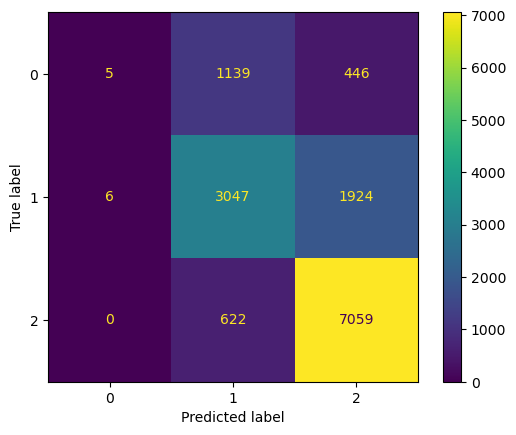

0.70964345873105


In [30]:
cm = confusion_matrix(actual, vals)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(3))
disp.plot()
plt.show()
print(accuracy_score(vals, actual))

In [31]:
test_df = pd.read_csv("./test_data.csv")
test_df.shape

(30530, 136)

In [32]:
test_data = torch.tensor(test_df.values.astype(np.int64), dtype=torch.float32)
print(best_model.forward(test_data))

tensor([[ 1.0316,  4.6475, -5.2906],
        [-1.5375, -2.0335,  3.0317],
        [ 1.9290,  6.4632, -7.8397],
        ...,
        [ 2.2528,  6.3198, -7.6983],
        [ 2.4442,  6.5392, -7.7657],
        [ 0.2596,  3.9610, -3.7541]], grad_fn=<AddmmBackward0>)


In [33]:
output_probs = nn.Softmax(dim=-1)(model(test_data))
preds = torch.max(output_probs.data, 1)
vals = preds.indices.numpy()
vals

array([1, 2, 1, ..., 1, 1, 1])

Getting the output and then storing the ouput in submission_nn.csv file for submission

In [35]:
df_output = pd.read_csv("../canadian-hospital-re-admittance-challenge/sample_submission.csv")
df_output["readmission_id"] = vals
df_output.to_csv("submission_nn.csv", index=False)

### References
1. List of ICD-9 codes : https://en.wikipedia.org/wiki/List_of_ICD-9_codes
2. Optuna documentation : https://optuna.readthedocs.io/en/stable/
3. Pandas documentation : https://pandas.pydata.org/docs/
4. Numpy documentation : https://numpy.org/doc/1.26/user/index.html
5. Scikit learn documentation : https://scikit-learn.org/stable/
6. Pytorch documentation : https://pytorch.org/docs/stable/index.html